[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/matteo-bertini/Facial-Expression-Recognition)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matteo-bertini/Facial-Expression-Recognition/blob/main/Five_Layers_CNN.ipynb)

# Importing the libraries
The libraries to implement Five-Layers-CNN and related utilities are imported here.

In [1]:
import random
import pickle
import seaborn as sn
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras,convert_to_tensor
from tensorflow.keras.regularizers import L2
from sklearn.model_selection import train_test_split,StratifiedKFold
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D,ReLU,RandomRotation
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Utilities
Here we declare some functions that will be useful later.

In [2]:
# Returns a batch with n samples from the set passed in input
def random_images(X,y,n):
  X_len = X.shape[0]
  ran_indices = random.sample(range(0,X_len,1),n)
  to_ret_X = []
  to_ret_y = []
  for i in range(0,n):
    to_ret_X.append(X[ran_indices[i]])
    to_ret_y.append(y[ran_indices[i]])

  return tf.stack(to_ret_X),tf.stack(to_ret_y)

# Plots the images and their labels passed in input 
def print_images_with_labels(X,y):
  emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
  num_images = X.shape[0]
  fig = plt.figure(figsize = (2*num_images,2*num_images))
  for i in range(0,num_images):
    fig.add_subplot(1,num_images,i+1)
    plt.axis("off")
    plt.imshow(X[i].numpy().reshape(48,48),cmap="gray")
    plt.title(emotions[y[i].numpy().argmax()])
  plt.show(fig)
  return

# GPU Check
This section checks whether the GPU is in use or not.

In [3]:
num_gpu_available = len(tf.config.list_physical_devices('GPU'))
if num_gpu_available == 0 :
  print("You are not using GPU.\n")
else:
  print("You are using GPU.\n")

You are using GPU.



In [4]:
# Command to run to see the specs of the assigned GPU. (only valid if GPU is in use)
!nvidia-smi

Fri Jan 20 09:14:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mounting Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset
The dataset provided by the file "icml_face.csv" file is uploaded and processed here.\
Specifically:


*   the csv file is transformed into a dataframe
*   the pixel column is manipulated so that it no longer contains 
    pixel strings but numpy arrays of size 48x48x1





In [6]:
# Loading icml_face_data.csv into dataframe df_icml
df_icml = pd.read_csv("/content/drive/MyDrive/Facial-Expression-Recognition/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv",sep=",")

# Columns renamed for easier access.
df_icml.rename(columns = {' Usage':'usage'}, inplace = True)
df_icml.rename(columns = {' pixels':'pixels'}, inplace = True)

# Transforming pixel strings into 48x48 tensors of float32
df_icml["pixels"] = df_icml['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48,1).astype('float32'))                                                          


# Training the Five-Layers-CNN in the classic way
In this section the Five-Layers-CNN will be trained in the "classical" way, that is by dividing the dataset into Train-Validation and Test sets.\
The Train set will be used to train the net, the Validation set to validate it at the end of each training epoch and the Test set to view its performance at the end of the training session.

## Builiding the Five-Layers-CNN from scratch
Here the architecture of Five-Layers-CNN is created from scratch.

In [7]:
model = Sequential()
model._name = "Five-Layers-CNN"


# First Layer : Input

# Second Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),input_shape = (48, 48, 1),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model.add(Dropout(0.3))
#-------------------------------------------------------------------------------------------------------------------------------#

# Third Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model.add(Dropout(0.3))
#-------------------------------------------------------------------------------------------------------------------------------#

# Fourth Layer
#--------------------------------------------- ADDING THE 2D CONVOLUTION -------------------------------------------------------#
#model.add(Conv2D(filters = 512,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
#model.add(BatchNormalization())
#model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Flatten(name='flatten'))     
model.add(Dense(512))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))
model.add(Dense(7,activation='softmax'))


# After creating the structure of the network, we visualize it in a compact way.
model.summary()

Model: "Five-Layers-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 48, 48, 64)    

## Creating the Train-Val-Test split
Here the Train Set, Validation Set and Test Set are created.\
At the beginning the split was done according to the value of the "usage" column of the df_icml dataframe, but after noticing that using this strategy all the three sets were unbalanced, I opted to use the sklearn library. The functions made available by sklearn allow you to create sets in a proportional and balanced way.

In [8]:
# Creating the X numpyarray
X = df_icml["pixels"]
X = np.stack(X, axis=0)
# Images normalization
X = X/255.0
print("X has shape: ")
print(X.shape)

# Creating the y numpyarray
y = df_icml["emotion"].to_numpy()
y = to_categorical(y)
print("y has shape: ")
print(y.shape)

print("\n")

# Data Augmentation phase 

# Declaration of the ImageDataGenerator with the transformations to apply to generate new images
data_gen = ImageDataGenerator(rotation_range = 15,width_shift_range = 0.15,height_shift_range = 0.15,shear_range = 0.15,zoom_range = 0.15,horizontal_flip = True)

# Disgust Class 

# Creating the X numpyarray with samples from disgust class
X_disg = df_icml.loc[df_icml['emotion'].isin([1])]["pixels"]
X_disg = np.stack(X_disg, axis=0)
X_disg = X_disg/255.0
print("X_disg has shape: ")
print(X_disg.shape)

# Creating the y numpyarray with samples from disgust class
y_disg = np.zeros((547,7))
for i in range (0,y_disg.shape[0]):
  y_disg[i][1] = 1 
print("y_disg has shape: ")
print(y_disg.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_disg)
  it = data_gen.flow(X_disg,y_disg,batch_size = 547,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1


# Surprise Class 

# Creating the X numpyarray with samples from surprise class
X_surp = df_icml.loc[df_icml['emotion'].isin([5])]["pixels"]
X_surp = np.stack(X_surp, axis=0)
X_surp = X_surp / 255.0
print("X_surp has shape: ")
print(X_surp.shape)

# Creating the y numpyarray with samples from surprise class
y_surp = np.zeros((4002,7))
for i in range (0,y_surp.shape[0]):
  y_surp[i][5] = 1 
print("y_surp has shape: ")
print(y_surp.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_surp)
  it = data_gen.flow(X_surp,y_surp,batch_size = 200,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1

print(X.shape,y.shape)

# Creating the train,val,test split using sklearn library 
# ( the stratify option retains the same proportion of classes in the train and test
#  sets that are found in the entire original dataset,it helps in the building of balanced train-test splits)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,shuffle=True,stratify=y_test,random_state=42)

# Transforming sets from numpy array to tensors
X_train = convert_to_tensor(X_train)
X_val = convert_to_tensor(X_val)
X_test = convert_to_tensor(X_test)
print("Sets shapes:")
print("X_train has shape: ")
print(X_train.shape)
print("y_train has shape: ")
print(y_train.shape)
print("X_val has shape: ")
print(X_val.shape)
print("y_val has shape: ")
print(y_val.shape)
print("X_test has shape: ")
print(X_test.shape)
print("y_test has shape: ")
print(y_test.shape)


X has shape: 
(35887, 48, 48, 1)
y has shape: 
(35887, 7)


X_disg has shape: 
(547, 48, 48, 1)
y_disg has shape: 
(547, 7)


X_surp has shape: 
(4002, 48, 48, 1)
y_surp has shape: 
(4002, 7)


(42610, 48, 48, 1) (42610, 7)
Sets shapes:
X_train has shape: 
(34088, 48, 48, 1)
y_train has shape: 
(34088, 7)
X_val has shape: 
(4261, 48, 48, 1)
y_val has shape: 
(4261, 7)
X_test has shape: 
(4261, 48, 48, 1)
y_test has shape: 
(4261, 7)


## Assignment of class weights
In this section, class weights are calculated and assigned. These weights are useful in the training phase to manage the imbalance between classes that emerged in the Exploratory Data Analysis.\
The following formula will be used to calculate the class weights:\
          **wj = n_samples / (n_classes * n_samplesj)**\
where:


*   wj is the weight for each class (j is the index of the class)
*   n_samples is the total number of samples or rows in the dataset
*   n_classes is the total number of unique classes in the dataset
*   n_samplesj is the total number of rows of the respective class (j is the index of the class)





In [9]:
# computing the total number of samples in the train set
n_samples = y_train.shape[0]

# declaration of the weights dictionary to pass in the training phase
weights = {0:0.0,1:0.0,2:0.0,3:0.0,4:0.0,5:0.0,6:0.0}

# counting n_samples j for each class
for j in range(n_samples):
  idx = y_train[j].argmax()
  weights[idx]=weights[idx]+1

print(weights)
# computing the weights for each class
for j in range(7):
  weights[j] = n_samples/ (7* weights[j])

# visualizing the weights
display(weights)

{0: 3962.0, 1: 4376.0, 2: 4097.0, 3: 7191.0, 4: 4862.0, 5: 4642.0, 6: 4958.0}


{0: 1.2291050695896732,
 1: 1.1128231914337947,
 2: 1.1886049025419296,
 3: 0.6771957009754256,
 4: 1.001586648645472,
 5: 1.049055210192651,
 6: 0.9821932807007434}

## Training
In this section the model is compiled, in particular are defined:

* the loss function (categorical crossentropy)
* the optimizator (adam optimizer)
* the evaluation metrics (accuracy)

After, the model is trained on the Training set and convalidated on the Validation set.

In [10]:
# defining the loss function,the optimizer and the evaluation metrics
opt = keras.optimizers.Adam(learning_rate = 1.1e-4)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)


In [11]:
# defining some callbacks 

# this callback reduces learning rate when the metric passed has stopped improving (prevents overfitting)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=2,min_lr=0,verbose=1)

# this callback stops training when a monitored metric has stopped improving (prevents overfitting)
early_stopping = EarlyStopping(monitor = "val_loss",min_delta = 0.0035,patience = 2,verbose = 1)

callbacks = [early_stopping]

In [12]:
# Training the model 

print("Training:\n")
num_epochs = 12
batch_size = 256
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=num_epochs,callbacks=callbacks,validation_data=(X_val, y_val),class_weight=weights)

# Saving the history to visualize the learning curves even without having trained the network (future use)
in1 = int(input("Do you want to save this training history? (1 = yes,0= no)"))
if(in1 == 1):
  with open("/content/drive/MyDrive/Facial-Expression-Recognition/Five-Layers-CNN (Classic)/Five_Layers_CNN_history.pi", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
else:
  pass

Training:

Epoch 1/12
134/134 [==============================] - 32s 155ms/step - loss: 10.5075 - accuracy: 0.3076 - val_loss: 11.4555 - val_accuracy: 0.1291
Epoch 2/12
134/134 [==============================] - 20s 150ms/step - loss: 9.2876 - accuracy: 0.4086 - val_loss: 10.4538 - val_accuracy: 0.1396
Epoch 3/12
134/134 [==============================] - 20s 150ms/step - loss: 8.2729 - accuracy: 0.4630 - val_loss: 8.6482 - val_accuracy: 0.2492
Epoch 4/12
134/134 [==============================] - 20s 149ms/step - loss: 7.3932 - accuracy: 0.4986 - val_loss: 7.5592 - val_accuracy: 0.3621
Epoch 5/12
134/134 [==============================] - 20s 148ms/step - loss: 6.6339 - accuracy: 0.5361 - val_loss: 6.8406 - val_accuracy: 0.4004
Epoch 6/12
134/134 [==============================] - 20s 149ms/step - loss: 5.9811 - accuracy: 0.5659 - val_loss: 6.2174 - val_accuracy: 0.4203
Epoch 7/12
134/134 [==============================] - 20s 149ms/step - loss: 5.4194 - accuracy: 0.5863 - val_loss: 5

## Learning curves visualization
Here the learning curves are displayed.\
In particular, it is displayed how the loss and accuracy change for the training set and for the validation set during the various training epochs.

In [13]:
# Loading training history from saved file
with open("/content/drive/MyDrive/Facial-Expression-Recognition/Five-Layers-CNN (Classic)/Five_Layers_CNN_history.pi", "rb") as file_pi:
    history = pickle.load(file_pi)

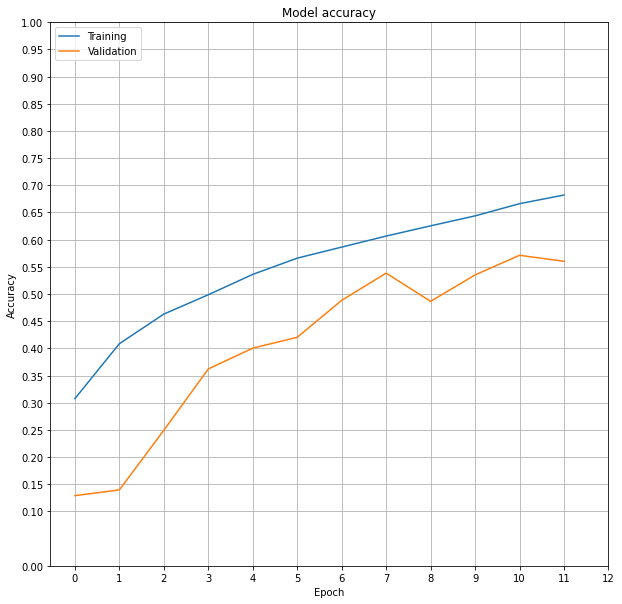

In [16]:
# visualizing the accuracy learning curves

# creating the figure
acc_lc = plt.figure(figsize = (10,10))

# plotting training and validation accuracy
plt.plot(history["accuracy"])                                                         
plt.plot(history['val_accuracy'])  

# setting plot title
plt.title('Model accuracy')

# setting x and y ticks and labels for the plot
plt.ylabel('Accuracy')
plt.yticks([0.0,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.0])
plt.xlabel('Epoch')
plt.xticks(range(0,num_epochs+1))

# setting the legend for the plot
plt.legend(['Training', 'Validation'], loc='upper left')

# adding the grid
plt.grid()

# showing the figure
plt.show(acc_lc)

Osservando la learning curve relativa all'accuracy si può notare che:

* la training accuracy cresce fino all'epoca numero 20 dell'allenamento,dopo la quale la crescita inizia a rallentare fino ad arrivare ad un plateau.  
*  la validation accuracy cresce fino all'epoca 15,dopo la quale la crescita rallenta fino ad arrivare al plateau.
* c'è un distacco costante di circa 0.2 tra la train accuracy e la validation accuracy,elemento su cui si può lavorare per migliorare il modello. Un modo per ridurre il gap fra le due curve e quindi migliorare il modello è quello di fornire più dati,in modo che il modello possa generalizzare meglio e quindi comportarsi meglio sul validation set. Un altro modo è il tuning del dropout e delle regolarizzazioni: ad esempio parametrizzando il dropout i neuroni non impareranno informazioni ridondanti,conservando solo quelle utili.



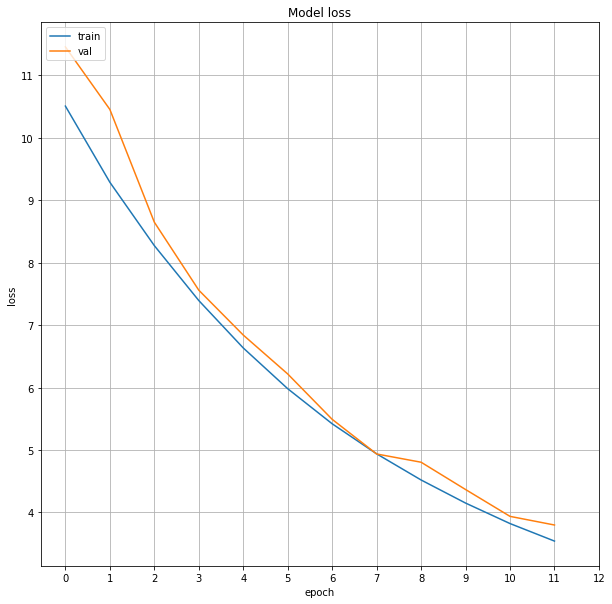

In [17]:
# visualizing the loss learning curves

# creating the figure
loss_lc = plt.figure(figsize = (10,10))

# plotting training and validation accuracy
plt.plot(history['loss'])                                                         
plt.plot(history['val_loss'])  

# setting plot title
plt.title('Model loss')

# setting x and y ticks and labels for the plot
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,num_epochs+1))

# setting the legend for the plot
plt.legend(['train', 'val'], loc='upper left')

# adding the grid
plt.grid()

# showing the figure
plt.show(loss_lc)

## Testing 
In this section the test phase is carried out for the net that has just been trained.


In [18]:
test_history_cl = model.evaluate(X_test,y_test,batch_size = 8)
print("Test Loss : %f , Test Accuracy : %f" %(test_history_cl[0],test_history_cl[1]))

533/533 [==============================] - 3s 5ms/step - loss: 3.8298 - accuracy: 0.5548
Test Loss : 3.829751 , Test Accuracy : 0.554799


## Visualizing the confusion matrix


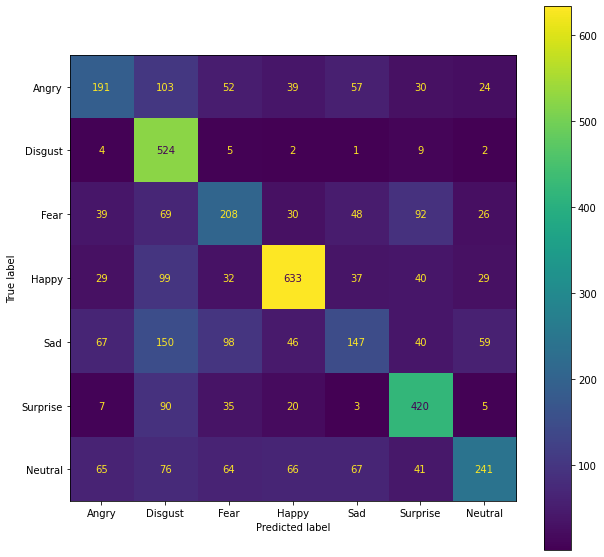

In [19]:
# computing the predictions on the test set
y_pred=model.predict(X_test,verbose=0) 

# creating the confusion matrix and the confusion matrix display
cm = confusion_matrix( y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(cm,display_labels=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"])

# creating the figure and axes
fig, ax = plt.subplots(figsize=(10,10))

# plotting the confusion matrix
cm_display = cm_display.plot(ax=ax)

### Confusion matrix analysis
Osservando la confusion matrix si evince che:
* il modello a volte confonde maggiormente le classi "Angry","Fear","Neutral" e "Sad" fra loro. Ciò è dovuto al fatto che ogni soggetto (sample) nel dataset esprime un'emozione in maniera differente e personale,introducendo ambiguità e rendendo il processo di apprendimento più complicato. Infatti esplorando il dataset si noterà che alcune immagini sono categorizzate in un'emozione,quando invece potrebbero tranquillamente rappresentare altre emozioni.
In più alcune foto mostrano il soggetto solo in parte e avolte hanno una cattiva illuminazione che non lo rende ben visibile.
Una soluzione al problema delle classificazioni errate è quella di agiungere al dataset immagini chiare che non mostrano ambiguità nell'emozione espressa dal soggetto,in questo modo il modello sarebbe in grado di cogliere meglio gli aspetti salienti di ogni emozione.
 

## Computing classification report and class accuracy

In [20]:
# Visualizing the classification report
print("Classification report: \n")
emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
print(classification_report(y_test.argmax(1),y_pred.argmax(1),labels = [0,1,2,3,4,5,6],target_names = emotions))
print("\n")

# Computing and visualizing class accuracy

print("Class accuracy: \n")
cl_acc = []
tp_p_tn = cm.diagonal().sum()
for i in range(7):
  fp = cm[:,i].sum()
  fn = cm[i].sum()
  acc = tp_p_tn / (tp_p_tn+fp+fn-2*cm[i][i])
  cl_acc.append(acc)

for i in range(7):
  print("%s : %f\n"%(emotions[i],cl_acc[i]))
  



Classification report: 

              precision    recall  f1-score   support

       Angry       0.48      0.39      0.43       496
     Disgust       0.47      0.96      0.63       547
        Fear       0.42      0.41      0.41       512
       Happy       0.76      0.70      0.73       899
         Sad       0.41      0.24      0.30       607
    Surprise       0.62      0.72      0.67       580
     Neutral       0.62      0.39      0.48       620

    accuracy                           0.55      4261
   macro avg       0.54      0.54      0.52      4261
weighted avg       0.56      0.55      0.54      4261



Class accuracy: 

Angry : 0.820833

Disgust : 0.794889

Fear : 0.800271

Happy : 0.834451

Sad : 0.778400

Surprise : 0.851585

Neutral : 0.818560



## Saving the model
After training and testing the model we save it for future use.

In [21]:
model.save("/content/drive/MyDrive/Facial-Expression-Recognition/Five-Layers-CNN (Classic)/Five_Layers_CNN_Classic.h5")

## Visualizing model performances
In this section the trained model will be loaded and then its performances will be displayed.\
More specifically:


*   A random batch of images will be extracted from the Test Set.
*   The extracted images will be displayed with their real labels (groundtruth)
* The extracted images will be displayed with the labels predicted by the model



In [22]:
# Loading the model
model = load_model("/content/drive/MyDrive/Facial-Expression-Recognition/Five-Layers-CNN (Classic)/Five_Layers_CNN_Classic.h5")

Enter the number of random images to extract: 15
Groundtruth:



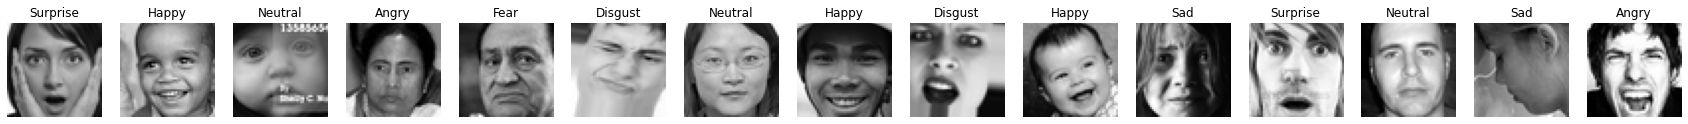



Model predictions:



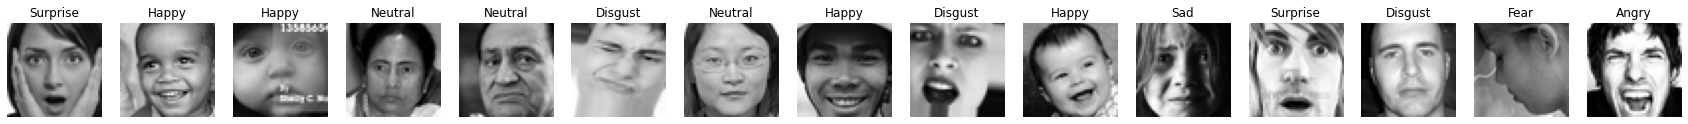

In [23]:
# Getting the number of random images to extract from the user
n = int(input("Enter the number of random images to extract: "))

# Generating the random images batch
images,labels = random_images(X_test,y_test,n)

# Visualizing the images with their real labels
print("Groundtruth:\n")
print_images_with_labels(images,labels)
print("\n")

# Visualizing the images with the predicted labels
pred = convert_to_tensor(model(images))
print("Model predictions:\n")
print_images_with_labels(images,pred)

# Training the Five-Layers-CNN using Stratified K-Fold Strategy
In this section Five-Layers-CNN will be trained following the K-Fold Cross Validation strategy. It was decided to implement this strategy to combat the previously encountered overfitting.

## Builiding the Five-Layers-CNN from scratch
Here the architecture of Five-Layers-CNN is created from scratch.



In [27]:
model2 = Sequential()
model2._name = "Five-Layers-CNN"


# First Layer : Input

# Second Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model2.add(Conv2D(filters = 64,kernel_size = (3, 3),input_shape = (48, 48, 1),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model2.add(BatchNormalization())
model2.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model2.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model2.add(BatchNormalization())
model2.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model2.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model2.add(BatchNormalization())
model2.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model2.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model2.add(Dropout(0.3))
#-------------------------------------------------------------------------------------------------------------------------------#

# Third Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model2.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model2.add(BatchNormalization())
model2.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model2.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model2.add(BatchNormalization())
model2.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model2.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model2.add(Dropout(0.3))
#-------------------------------------------------------------------------------------------------------------------------------#

# Fourth Layer
#--------------------------------------------- ADDING THE 2D CONVOLUTION -------------------------------------------------------#
#model.add(Conv2D(filters = 512,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
#model.add(BatchNormalization())
#model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model2.add(Flatten(name='flatten'))     
model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(ReLU())
model2.add(Dropout(0.3))
model2.add(Dense(7,activation='softmax'))


# After creating the structure of the network, we visualize it in a compact way.
model2.summary()

Model: "Five-Layers-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 48, 48, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_7 (ReLU)              (None, 48, 48, 64)    

## Creating the Train-Test split
In this section the split is created with the use of the sklearn library.\
This is useful for applying the Stratified K-Fold Cross Validation strategy.

In [28]:
# Creating the X numpyarray
X = df_icml["pixels"]
X = np.stack(X, axis=0)
print("X has shape: ")
print(X.shape)

# Creating the y numpyarray
y = df_icml["emotion"].to_numpy()
y = to_categorical(y)
print("y has shape: ")
print(y.shape)

# Data Augmentation phase 

# Declaration of the ImageDataGenerator with the transformations to apply to generate new images
data_gen = ImageDataGenerator(rotation_range = 15,width_shift_range = 0.15,height_shift_range = 0.15,shear_range = 0.15,zoom_range = 0.15,horizontal_flip = True)

# Disgust Class 

# Creating the X numpyarray with samples from disgust class
X_disg = df_icml.loc[df_icml['emotion'].isin([1])]["pixels"]
X_disg = np.stack(X_disg, axis=0)
print("X_disg has shape: ")
print(X_disg.shape)

# Creating the y numpyarray with samples from disgust class
y_disg = np.zeros((547,7))
for i in range (0,y_disg.shape[0]):
  y_disg[i][1] = 1 
print("y_disg has shape: ")
print(y_disg.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_disg)
  it = data_gen.flow(X_disg,y_disg,batch_size = 547,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1


# Surprise Class 

# Creating the X numpyarray with samples from surprise class
X_surp = df_icml.loc[df_icml['emotion'].isin([5])]["pixels"]
X_surp = np.stack(X_surp, axis=0)
print("X_surp has shape: ")
print(X_surp.shape)

# Creating the y numpyarray with samples from surprise class
y_surp = np.zeros((4002,7))
for i in range (0,y_surp.shape[0]):
  y_surp[i][5] = 1 
print("y_surp has shape: ")
print(y_surp.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_surp)
  it = data_gen.flow(X_surp,y_surp,batch_size = 200,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1


print("\n")
# Creating the train,val,test split using sklearn library 
# ( the stratify option retains the same proportion of classes in the train and test
#  sets that are found in the entire original dataset,it helps in the building of balanced train-test splits)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True,stratify=y)

print("Numpy array shapes:")
print("X_train has shape: ")
print(X_train.shape)
print("y_train has shape: ")
print(y_train.shape)
print("X_test has shape: ")
print(X_test.shape)
print("y_test has shape: ")
print(y_test.shape)

print("\n")
# Transforming sets from numpy array to tensors
X_train = convert_to_tensor(X_train)
X_test = convert_to_tensor(X_test)
print("Tensor shapes:")
print("X_train has shape: ")
print(X_train.shape)
print("y_train has shape: ")
print(y_train.shape)
print("X_test has shape: ")
print(X_test.shape)
print("y_test has shape: ")
print(y_test.shape)

X has shape: 
(35887, 48, 48, 1)
y has shape: 
(35887, 7)
X_disg has shape: 
(547, 48, 48, 1)
y_disg has shape: 
(547, 7)


X_surp has shape: 
(4002, 48, 48, 1)
y_surp has shape: 
(4002, 7)




Numpy array shapes:
X_train has shape: 
(29827, 48, 48, 1)
y_train has shape: 
(29827, 7)
X_test has shape: 
(12783, 48, 48, 1)
y_test has shape: 
(12783, 7)


Tensor shapes:
X_train has shape: 
(29827, 48, 48, 1)
y_train has shape: 
(29827, 7)
X_test has shape: 
(12783, 48, 48, 1)
y_test has shape: 
(12783, 7)


## Assignment of class weights
In this section, class weights are calculated and assigned. These weights are useful in the training phase to manage the imbalance between classes that emerged in the Exploratory Data Analysis.
The following formula will be used to calculate the class weights:\
          **wj = n_samples / (n_classes * n_samplesj)**\
where:


*   wj is the weight for each class (j is the index of the class)
*   n_samples is the total number of samples or rows in the dataset
*   n_classes is the total number of unique classes in the dataset
*   n_samplesj is the total number of rows of the respective class (j is the index of the class)





In [29]:
# computing the total number of samples in the train set
n_samples = y_train.shape[0]

# declaration of the weights dictionary to pass in the training phase
weights = {0:0.0,1:0.0,2:0.0,3:0.0,4:0.0,5:0.0,6:0.0}

# counting n_samples j for each class
for j in range(n_samples):
  idx = y_train[j].argmax()
  weights[idx]=weights[idx]+1

# computing the weights for each class
for j in range(7):
  weights[j] = n_samples/ (7* weights[j])

# visualizing the weights
display(weights)

{0: 1.2290164407268531,
 1: 1.1128231914337947,
 2: 1.1885634588563458,
 3: 0.6772091544818818,
 4: 1.0016455101081336,
 5: 1.049248953459739,
 6: 0.9820235077206729}

## Training
In this section the model is compiled, in particular are defined:

* the loss function (categorical crossentropy)
* the optimizator (adam optimizer)
* the evaluation metrics (accuracy)

After, the model is trained using the K-Fold Cross Validation strategy.

In [30]:
# defining the loss function,the optimizer and the evaluation metrics
opt = keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)

In [31]:
# Declaration of the Stratified K-Fold object 
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1) 

# Declaration of the array in which the loss and accuracy of the evaluation phase of each fold will be stored
folds_results = []

# Declaration of fold index variable 
fold_idx = 1

# Iteration through various folds
for train_index, val_index in skf.split(X_train, y_train.argmax(1)): 
   
    # Creating the train and val folds
    # We will use the train fold to train the model and the val to evaluate the model performance
    X_train_fold, X_val_fold = X[train_index], X[val_index] 
    y_train_fold, y_val_fold = y[train_index], y[val_index] 

    # Training the model
    print("----------------------------------------------------------------------------------------------------------------")
    print("Training the model with the fold number %d\n" %(fold_idx))
    history = model.fit(X_train_fold, y_train_fold,epochs=5,batch_size=32,class_weight=weights) 
    print("\n")

    # Evaluating the model
    print("Evaluating the model with the fold number %d\n" %(fold_idx))
    folds_results.append(model.evaluate(X_val_fold, y_val_fold))
    print("\n")

    # Updating fold index
    fold_idx = fold_idx+1

----------------------------------------------------------------------------------------------------------------
Training the model with the fold number 1

Epoch 1/5
839/839 [==============================] - 21s 23ms/step - loss: 3.4928 - accuracy: 0.5720
Epoch 2/5
839/839 [==============================] - 19s 23ms/step - loss: 3.0030 - accuracy: 0.6086
Epoch 3/5
839/839 [==============================] - 21s 25ms/step - loss: 2.6000 - accuracy: 0.6463
Epoch 4/5
839/839 [==============================] - 22s 26ms/step - loss: 2.2835 - accuracy: 0.6616
Epoch 5/5
839/839 [==============================] - 19s 22ms/step - loss: 2.0133 - accuracy: 0.6917


Evaluating the model with the fold number 1

94/94 [==============================] - 1s 9ms/step - loss: 2.0743 - accuracy: 0.6376


----------------------------------------------------------------------------------------------------------------
Training the model with the fold number 2

Epoch 1/5
839/839 [============================

In [32]:
# Getting the average model accuracy
avg_accuracy = 0.0
avg_loss = 0.0
for i in folds_results:
  avg_loss = avg_loss + i[0]
  avg_accuracy = avg_accuracy + i[1]

avg_accuracy = avg_accuracy/n_splits
avg_loss = avg_loss / n_splits

print("Average model accuracy : %f\n" %(avg_accuracy))
print("Average model loss : %f\n" %(avg_loss))

Average model accuracy : 0.886254

Average model loss : 0.697126



## Testing
In this section the test phase is carried out for the net that has just been trained.


In [33]:
test_history = model.evaluate(X_test,y_test,batch_size = 8)
print("Test Loss : %f , Test Accuracy : %f" %(test_history[0],test_history[1]))

1598/1598 [==============================] - 7s 4ms/step - loss: 1.0169 - accuracy: 0.8128
Test Loss : 1.016922 , Test Accuracy : 0.812798


## Visualizing the confusion matrix


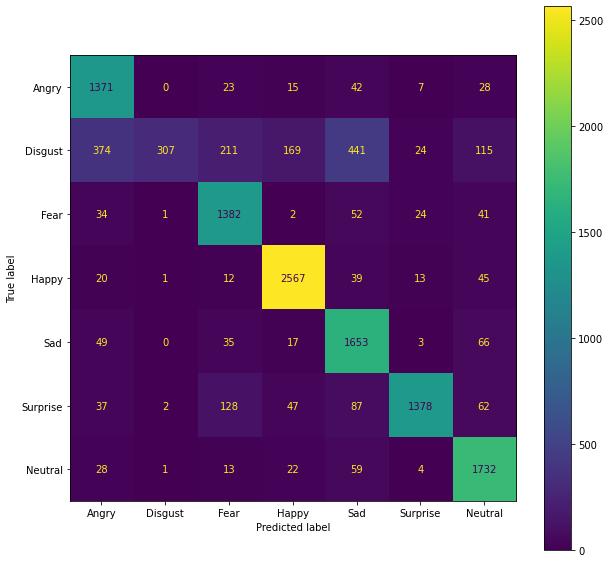

In [34]:
# computing the predictions on the test set
y_pred=model.predict(X_test,verbose=0) 

# creating the confusion matrix and the confusion matrix display
cm = confusion_matrix( y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(cm,display_labels=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"])

# creating the figure and axes
fig, ax = plt.subplots(figsize=(10,10))

# plotting the confusion matrix
cm_display.plot(ax=ax)

## Computing class accuracy

In [35]:
# Visualizing the classification report
print("Classification report: \n")
emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
print(classification_report(y_test.argmax(1),y_pred.argmax(1),labels = [0,1,2,3,4,5,6],target_names = emotions))
print("\n")

# Computing and visualizing class accuracy

print("Class accuracy: \n")
cl_acc = []
tp_p_tn = cm.diagonal().sum()
for i in range(7):
  fp = cm[:,i].sum()
  fn = cm[i].sum()
  acc = tp_p_tn / (tp_p_tn+fp+fn-2*cm[i][i])
  cl_acc.append(acc)

for i in range(7):
  print("%s : %f\n"%(emotions[i],cl_acc[i]))
  



Classification report: 

              precision    recall  f1-score   support

       Angry       0.72      0.92      0.81      1486
     Disgust       0.98      0.19      0.31      1641
        Fear       0.77      0.90      0.83      1536
       Happy       0.90      0.95      0.93      2697
         Sad       0.70      0.91      0.79      1823
    Surprise       0.95      0.79      0.86      1741
     Neutral       0.83      0.93      0.88      1859

    accuracy                           0.81     12783
   macro avg       0.83      0.80      0.77     12783
weighted avg       0.84      0.81      0.79     12783



Class accuracy: 

Angry : 0.940527

Disgust : 0.885839

Fear : 0.947474

Happy : 0.962750

Sad : 0.921099

Surprise : 0.959549

Neutral : 0.955490



## Saving the model
After training and testing the model we save it for future use.

In [36]:
model.save("/content/drive/MyDrive/Facial-Expression-Recognition/Five-Layers-CNN (K-Fold)/Five_Layers_CNN_Classic.h5")

## Visualizing model performances
In this section the trained model will be loaded and then its performances will be displayed.\
More specifically:


*   A random batch of images will be extracted from the Test Set.
*   The extracted images will be displayed with their real labels (groundtruth)
* The extracted images will be displayed with the labels predicted by the model



In [37]:
# Loading the model
model = load_model("/content/drive/MyDrive/Facial-Expression-Recognition/Five-Layers-CNN (K-Fold)/Five_Layers_CNN_Classic.h5")

Enter the number of random images to extract: 20
Groundtruth:



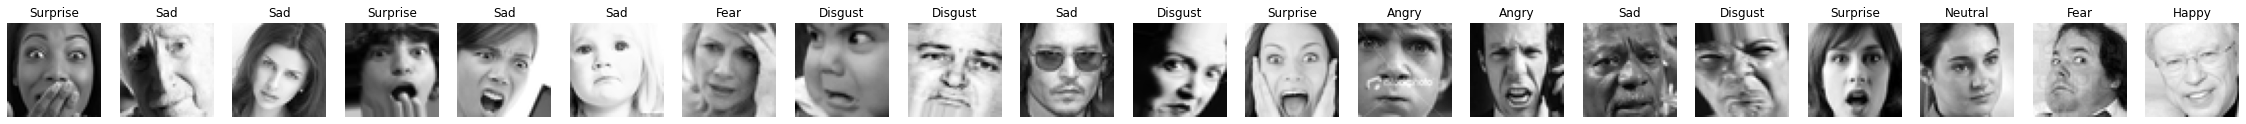



Model predictions:



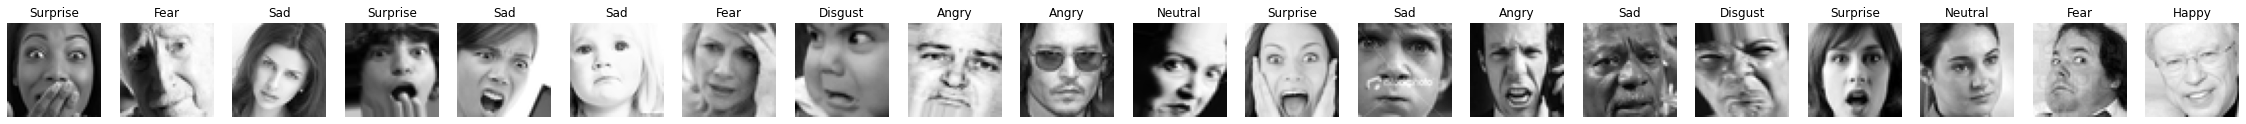

In [38]:
# Getting the number of random images to extract from the user
n = int(input("Enter the number of random images to extract: "))

# Generating the random images batch
images,labels = random_images(X_test,y_test,n)

# Visualizing the images with their real labels
print("Groundtruth:\n")
print_images_with_labels(images,labels)
print("\n")

# Visualizing the images with the predicted labels
pred = convert_to_tensor(model(images))
print("Model predictions:\n")
print_images_with_labels(images,pred)